### Come back to [Introduction](Introduction.ipynb)

<a id="top"/>

# DATA PROCESSING

>The content of this notebook is:

>1. [Data preparation](#dataprep)
>1. [Filtering of categories](#filter)
>1. [Structures](#struc)

<a id="dataprep"/>

##   Data preparation
>In this section we decide the libraries and the data structures we will use on the notebook, but also perform the initial preprocessing of the data to a shape which is best for use in further analysis. We will show:
* where we obtain our data
* convert the data to a form that it will be easier to use


### Obtain the Data
>_Amazon Customer Reviews (a.k.a. Product Reviews) is one of Amazon’s iconic products. In a period of over two decades since the first review in 1995, millions of Amazon customers have contributed over a hundred million reviews to express opinions and describe their experiences regarding products on the Amazon.com website. Over 130+ million customer reviews are available to researchers as part of this dataset. _[**Amazon Customer Reviews Dataset**](https://registry.opendata.aws/amazon-reviews/)

>[Amazon](http://www.amazon.com) provides a series of datasets through its website. A list of those datasets can be found [here](https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt). The link to download the dataset used for this projects can be downloaded from this [link](https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_multilingual_UK_v1_00.tsv.gz).
For further documentation, we provide this [link](https://s3.amazonaws.com/amazon-reviews-pds/readme.html).

### Data Manipulation
>The original form of the selected dataset is a .tsv(tab separated values) file an 333 MB in its compressed  state. When we decompressed the file, the dataset was 840 MB long. We decided to transform the dataset into a pandas.DataFrame object because pandas has built-in functionality for a lot of common data-processing applications: for example, easy group by syntax or easy joins.

>Here we import the modules that we will need in order to extract the data to manipulate them 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pickle
import seaborn as sns

>This variable will hold the path of our raw dataset

In [2]:
PATH_DATA = "C:/Users/Tosodoulis/Desktop/All The Folders/DTU Courses/First Semester/02805-Social Graphs and Interactions/final/final/"

In [3]:
"""
\brief The function returns the percentage given the value and its total 
\param value (int/float)
\param tot (int/float)
\return float: the actual percentage
"""
def percent(value,tot):
    return value/float(tot)*100

>We recognize that we have some data which are "corrupted". For those data, we are going to set the date to 1900-01-01. Then we are going to delete them.

In [4]:
def parserDate(x):
    try:
        return datetime.datetime.strptime(x, '%Y-%m-%d')
    except ValueError:
        return datetime.datetime.strptime("1900-01-01", '%Y-%m-%d')

>In this block, we make use of the **pandas** module, which helps us read the raw dataset and transform into a dataframe which is easier to read and extract information from it. From the original dataset, we are going to use only 8 out of the 14 columns. Those are: customer_id, product_id, product_title, product_category, star_rating, review_headline, review_body and review_date

In [5]:
df =  pd.read_csv(
    "%sdata.tsv" % PATH_DATA, 
    encoding="utf-8", 
    header=0,
    sep='\t',
    usecols=['customer_id', 'product_id', 'product_title','product_category','star_rating','review_headline','review_body','review_date'],
    dtype = {
        #'marketplace':str,
        'customer_id':str,
        #'review_id':str,
        'product_id':str,
        #'product_parent':str,
        'product_title':str,
        'product_category':str,
        'star_rating': np.uint8,
        #'helpful_votes': np.uint16,
        #'total_votes': np.uint16,
        #'vine':str,
        #'verified_purchase':bool,
        'review_headline':str,
        'review_body':str,
        },
    parse_dates = ['review_date'],
    true_values = ["Y"],
    false_values  = ["N"],
    skipinitialspace = True,
    date_parser=parserDate,
    infer_datetime_format = True,
    error_bad_lines = False,
    warn_bad_lines = True,
    engine='c',
    )

In [6]:
df.index.names = ['review_id']

>Here we represent a table with the first 10 raws of the that we just created. new dataframe that we just created.

In [9]:
df.head()

,customer_id,product_id,product_title,product_category,star_rating,review_headline,review_body,review_date
review_id,,,,,,,,
0,10349,B00MWK7BWG,My Favourite Faded Fantasy,Music,5,Five Stars,The best album ever!,2014-12-29
1,10629,B006CHML4I,Seiko 5 Men's Automatic Watch with Black Dial ...,Watches,4,Great watch from casio.,What a great watch. Both watches and strap is ...,2013-10-24
2,12136,B00IIFCJX0,Dexter Season 8,Digital_Video_Download,5,fantastic,"love watching all the episodes of Dexter, when...",2014-05-09
3,12268,B000W7JWUA,The Settlers of Catan Board Game - discontinue...,Toys,5,Five Stars,Excellent game!!!,2014-09-19
4,12677,B005JTAP4S,Peter: A Darkened Fairytale (Vol 1),Digital_Ebook_Purchase,5,A twist on Tales,"This cute, quick read is very different to say...",2013-09-18


In [10]:
df['review_date'] = pd.to_datetime(df['review_date'])

>Below, we check if there are corrupted data that cannot be used for further manipulation

In [11]:
print("There are %d rows of corrupted data" % df[df.review_date=="1900-01-01"].count()[0])

There are 55 rows of corrupted data


>And finally, we delete those raws from our dataset

In [12]:
df = df.drop(df[df.review_date=="1900-01-01"].index)

>Check if there are NaN values

In [13]:
print("There are %d of NaN values" % df.isnull().values.sum())

There are 21 of NaN values


>Removing rows which contain NaN values

In [14]:
df = df.dropna()

<a id="filter"/>

## Filtering of categories

>Since there are 33 categories in our dataset, we decided to exclude the ones with less reviews, precisely 1000 reviews. In this way we have filter out only the 0.19% of all dataset. The code below shows the methodology that we implemented. 

In [15]:
categories = sorted(df.product_category.unique().tolist())

In [16]:
tempCategories = []
delCategories = []
N = 1000 #inferior limit
for c in categories:
    if(df[df.product_category==c].count()[0])>=N:
        tempCategories.append(c)
    else:
        delCategories.append(c)
tot = df.count()[0]
NKeep = df[df['product_category'].isin(tempCategories)].count()[0]
NDisc = tot-NKeep
print("CATEGORIES KEEPED (%d): %s" % (len(tempCategories),", ".join(tempCategories)))
print("WE ARE KEEPING %d/%d (%.2f%%) REVIEWS" % (NKeep,tot,percent(NKeep,tot)))
print("\nCATEGORIES REMOVED (%d): %s" % (len(delCategories),", ".join(delCategories)))
print("WE ARE DISCARDING %d/%d (%.2f%%) REVIEWS" % (NDisc,tot,percent(NDisc,tot)))

CATEGORIES KEEPED (20): Baby, Books, Camera, Digital_Ebook_Purchase, Digital_Music_Purchase, Digital_Video_Download, Electronics, Home, Mobile_Apps, Music, Musical Instruments, PC, Shoes, Sports, Toys, Video, Video DVD, Video Games, Watches, Wireless
WE ARE KEEPING 1702443/1705765 (99.81%) REVIEWS

CATEGORIES REMOVED (13): Apparel, Automotive, Beauty, Health & Personal Care, Home Entertainment, Home Improvement, Kitchen, Lawn and Garden, Luggage, Office Products, Personal_Care_Appliances, Pet Products, Software
WE ARE DISCARDING 3322/1705765 (0.19%) REVIEWS


In [17]:
categories = tempCategories
df = df[df['product_category'].isin(categories)]

### Number of reviews

>The graph below shows the star rating of the reviews as seen by the customers

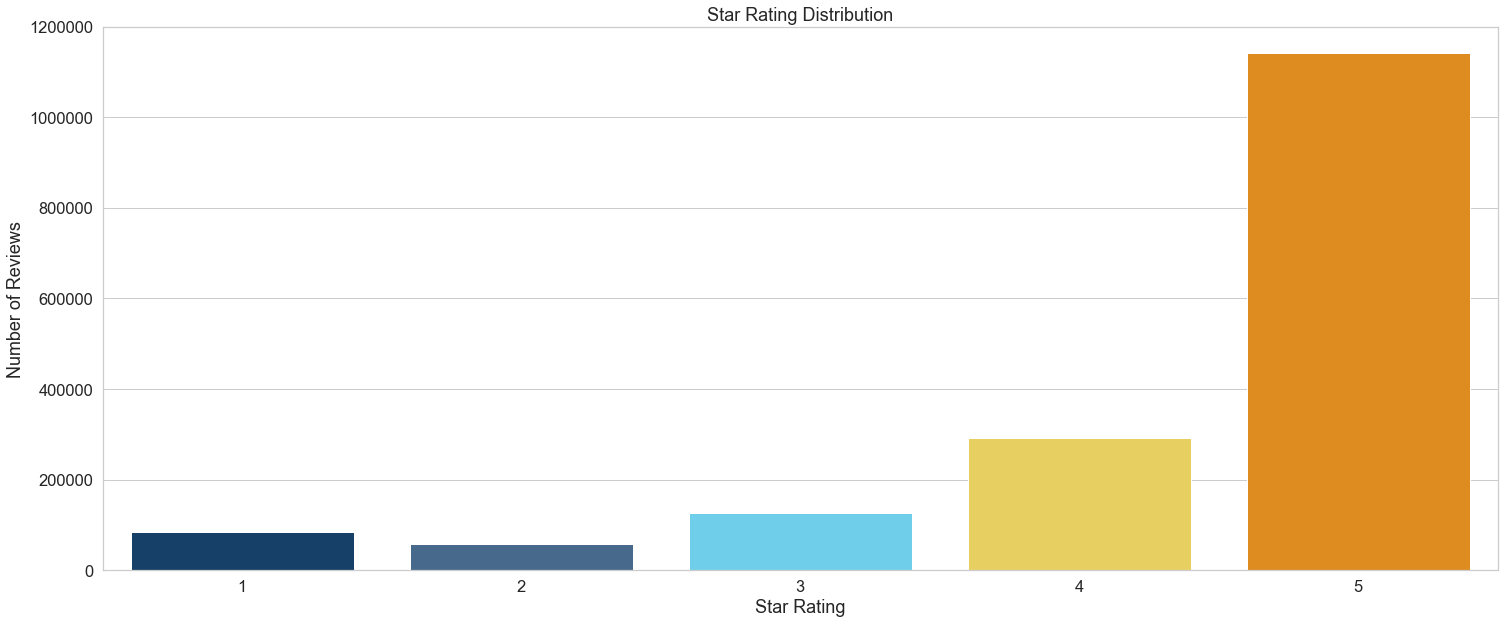

In [19]:
star_table = df[["star_rating","product_category"]].groupby(["star_rating"]).count().reset_index()
sns.set(font_scale=1.5,style="whitegrid",rc={'figure.figsize':(25,10)})
colors = ["#094074","#3c6997","#5adbff","#ffdd4a","#fe9000"]
sns.barplot(x ="star_rating",y ="product_category",palette=colors, data=star_table )
plt.title("Star Rating Distribution")
plt.xlabel("Star Rating")
plt.ylabel("Number of Reviews")
plt.show()

>And this graph shows the distribution of the reviews based on the category of the product

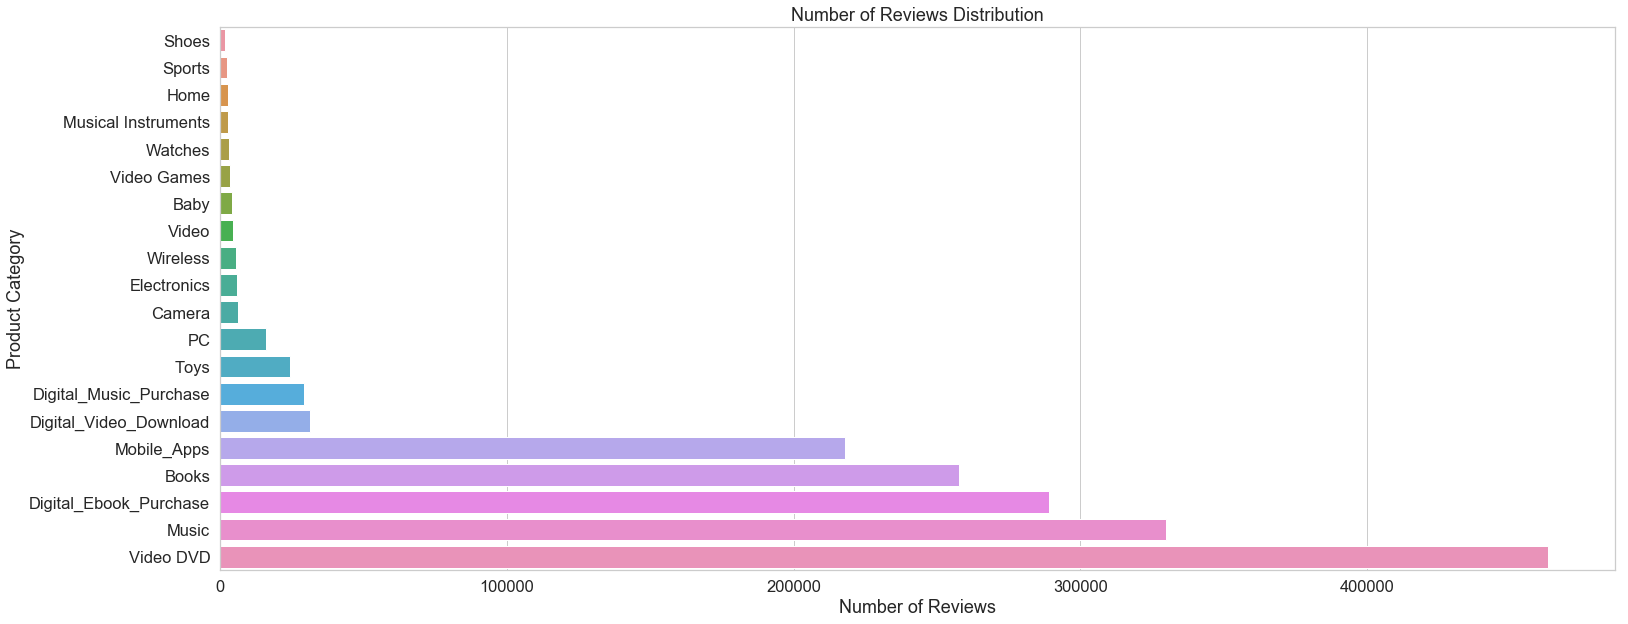

In [20]:
category_table = df[["product_category","review_headline"]].groupby(["product_category"]).count().reset_index().sort_values(["review_headline"])
sns.barplot(x="review_headline",y ="product_category", data=category_table)
plt.title("Number of Reviews Distribution")
plt.xlabel("Number of Reviews")
plt.ylabel("Product Category")
plt.show()

In [21]:
heatDF = df.groupby(["product_category","star_rating"]).count().reset_index()

>In the graph below we represent a heat-map that takes the Star-Rating and the Categories and finds correlations between those 2.

In [22]:
matrix = np.zeros([len(categories),5])
cat_ind = {cat:i for i,cat in enumerate(categories)}
for index, row in heatDF.iterrows():
    matrix[cat_ind[row[0]],row[1]-1] = row[2]

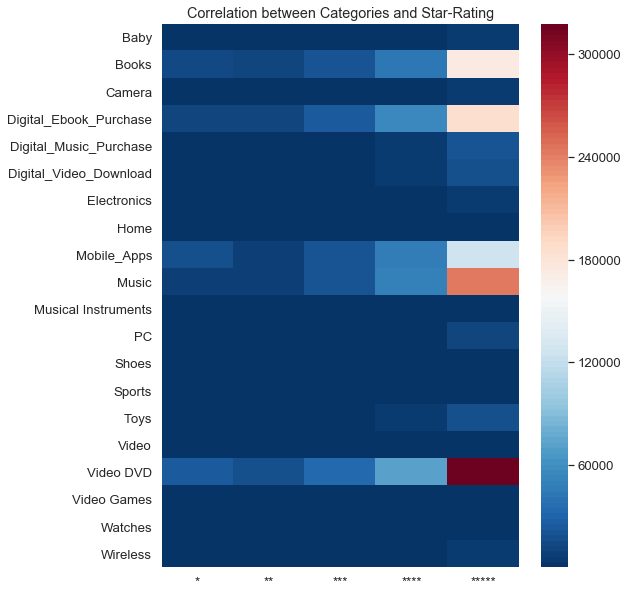

In [23]:
sns.set(font_scale=1.2,style="whitegrid",rc={'figure.figsize':(8,10)})
plt.title("Correlation between Categories and Star-Rating")
sns.heatmap(matrix, 
            xticklabels=['*'*i for i in range(1,6)], 
            yticklabels=categories,
           cmap=sns.color_palette("RdBu_r", 100),
           vmin=50)
plt.show()

<a id="struc"/>

## Structures 

>In order for us to work faster and me more immediate, we decided to save the pandas.dataframe object into a pickle file and store it locally. That saves us time because we read directly from the .pkl file instead of running again the code to reach a certain point.

In [24]:
df.to_pickle("%sAmazonDataProject.pkl" % PATH_DATA)

In [25]:
df_no_text = (df.drop(labels=["review_headline","review_body"],axis=1))

In [26]:
df_no_text.head()

,customer_id,product_id,product_title,product_category,star_rating,review_date
review_id,,,,,,
0,10349,B00MWK7BWG,My Favourite Faded Fantasy,Music,5,2014-12-29
1,10629,B006CHML4I,Seiko 5 Men's Automatic Watch with Black Dial ...,Watches,4,2013-10-24
2,12136,B00IIFCJX0,Dexter Season 8,Digital_Video_Download,5,2014-05-09
3,12268,B000W7JWUA,The Settlers of Catan Board Game - discontinue...,Toys,5,2014-09-19
4,12677,B005JTAP4S,Peter: A Darkened Fairytale (Vol 1),Digital_Ebook_Purchase,5,2013-09-18


In [27]:
df_no_text.to_pickle("%sAmazonDataProjectNoText.pkl" % PATH_DATA)

>[Back to the top](#top)